In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import pickle
import matplotlib.pyplot as plt
import vehicle_list_data
from simulation import Simulation
from vehicle_list_data import get_index_edge_totals
from tqdm import tqdm
from ast import literal_eval
from vehicle import get_edge_type_frequencies

In [3]:
file_path = "trials/wednesday_debug/"

# Labels

In [197]:
reverse_scenario_labels = ["all_improved", "double_battery_capacity", "double_km_per_kwh", "double_charging_rate", "baseline"]
scenario_labels = reversed(reverse_scenario_labels)

# Sort Pickles

In [200]:
def get_pickles_by_scenario(file_path):
    pkls = os.listdir(file_path)
    per_scenario = {str(n):[] for n in range(num_scenarios)}
    for scenario in range(num_scenarios):
        for pkl in pkls:
            end_index = pkl.find('_algorithm_')
            if "scenario_"+str(scenario) in pkl or pkl[end_index-1:end_index]==str(scenario):
                per_scenario[str(scenario)].append(pkl)
    per_scenario = {key:sorted(per_scenario[key]) for key in per_scenario}
    return per_scenario
per_scenario = get_pickles_by_scenario(file_path)

# Graph Scenarios over Algorithm Iterations

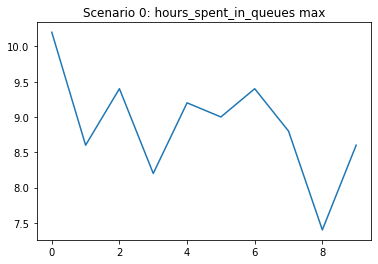

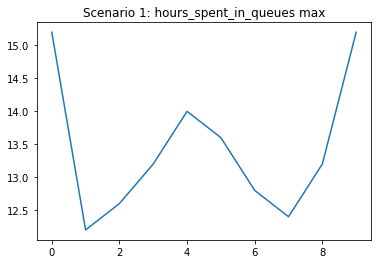

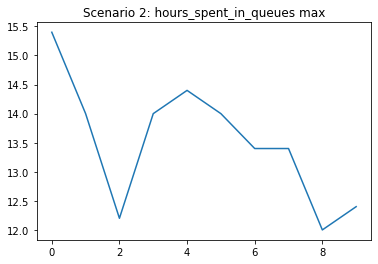

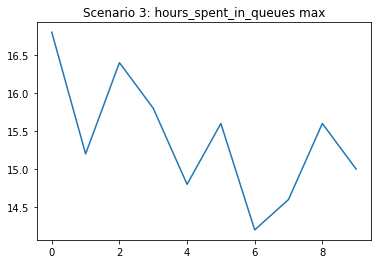

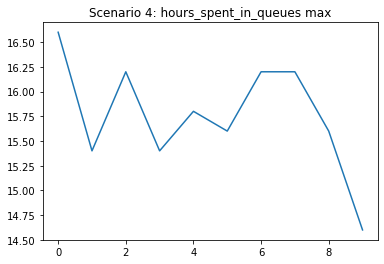

In [206]:
num_scenarios = len(list(per_scenario.keys()))
def graph_scenario(n, metric = "station_utilization_disp_of_avg", measurement=None):
    indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}
    data = []
    for pkl in per_scenario[str(n)]:
        with open(file_path + pkl, 'rb') as inp:
            sim = pickle.load(inp)
            if measurement != None:
                data.append(sim.metrics[metric][indices[measurement]])
            else:
                data.append(sim.metrics[metric])
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("Scenario " + str(n) + ": " + metric + " " + measurement_str)
    plt.show()

for scenario in range(num_scenarios):
    graph_scenario(scenario, metric = "hours_spent_in_queues", measurement = "max")

# Extract Charging Station Information

In [16]:
with open("debug_05_02_2022_20_36_34.pkl", 'rb') as inp:
    sim = pickle.load(inp)

In [16]:
def get_stations_used_passed(path):
    stations_used = []
    stations_passed = []
    for i, loc in enumerate(path):
        if i == len(path):
            break
        if "_in" in loc:
            next_loc = path[i+1]
            in_battery = loc.split("_")[1]
            out_battery = next_loc.split("_")[1]
            if "_out" in next_loc:
                node = loc.split("_")[0]
                if in_battery != out_battery:
                    stations_used.append(node)
                else:
                    stations_passed.append(node)
    return (stations_used, stations_passed)

def get_utilization_df(sim):
    station_used_counts = {node:0 for node in sim.station_g.nodes}
    station_passed_counts = {node:0 for node in sim.station_g.nodes}

    for vehicle in sim.vehicle_list:
        stations_used, stations_passed = get_stations_used_passed(vehicle.path)
        for station in stations_used:
            station_used_counts[station]+=1
        for station in stations_passed:
            station_passed_counts[station]+=1
    utilization_data = np.array([list(station_used_counts.keys()), list(station_used_counts.values()), list(station_passed_counts.values())]).T
    utilization_df = pd.DataFrame(utilization_data, columns = ["node", "used", "passed"])
    utilization_df = utilization_df.astype({"used": int, "passed": int})
    return utilization_df

def get_charging_passed_unseen(sim):
    utilization_df = get_utilization_df(sim)
    num_stations_unseen = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]==0)])
    num_stations_passed = len(utilization_df.loc[(utilization_df["used"]==0)&(utilization_df["passed"]!=0)])
    num_stations_charging = len(utilization_df.loc[(utilization_df["used"]!=0)])
    return (num_stations_charging, num_stations_passed, num_stations_unseen)

get_charging_passed_unseen(sim)

(25, 0, 18)

# Assess src-dst distribution

In [17]:
print("Total vehicles: ", len(sim.vehicle_list))

Total vehicles:  8644


['Oakland', 'Long Beach', 'San Diego', 'Fresno', 'Sacramento', 'Reno', 'Oregon']


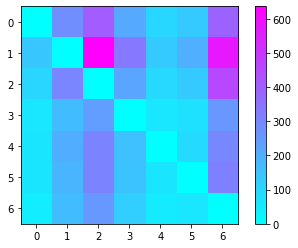

In [18]:
def plot_src_dst_matrix(sim):
    demand_nodes = list(sim.dst_dict.keys())
    num_demand_nodes = len(demand_nodes)
    destinations = {dst:0 for dst in demand_nodes}
    sources = {src:0 for src in demand_nodes}
    paths = {(src+"_src", dst+"_dst"):0 for src in demand_nodes for dst in demand_nodes}

    for vehicle in sim.vehicle_list:
        destinations[vehicle.dst]+=1
        sources[vehicle.src]+=1
        paths[(vehicle.src+"_src", vehicle.dst+"_dst")] +=1

    paths
    path_matrix = np.zeros((num_demand_nodes,num_demand_nodes))
    for r, src in enumerate(demand_nodes):
        for c, dst in enumerate(demand_nodes):
            path_matrix[r][c] = paths[(src+"_src",dst+"_dst")]
            
    plt.imshow(path_matrix, cmap='cool', interpolation='nearest')
    print(demand_nodes)
    plt.colorbar()
    plt.show()
plot_src_dst_matrix(sim)

# Static Graph

In [213]:
file_path = "trials/arizona_baseline_results/arizona_baseline_results_scenario_0_algorithm_4_05_04_2022_00_33_25.pkl"
with open(file_path, 'rb') as inp:
    sim = pickle.load(inp)

In [214]:
edge_totals = get_index_edge_totals(sim)

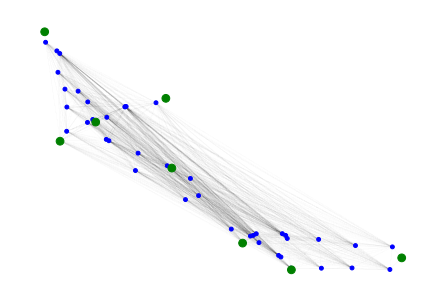

In [217]:
G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 15
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 60
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: G.nodes[node]["size"] for node in G.nodes}
widths = {edge:.005 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Assess demand (vehicles on each road)

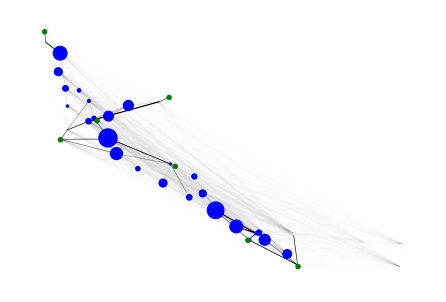

In [21]:
G = sim.station_demand_g
sim_index = 50
#colors
for node in G.nodes:
    G.nodes[node]["color"] = "blue"
    G.nodes[node]["size"] = 0
for node in nx.get_node_attributes(G,'demand'):
    G.nodes[node]["color"] = "green"
    G.nodes[node]["size"] = 20
node_color = nx.get_node_attributes(G,'color').values() 
node_size = {node: edge_totals[sim_index][(node, node)] if (node, node) in edge_totals[sim_index] else G.nodes[node]["size"] for node in G.nodes}
widths = {edge:edge_totals[sim_index][edge]/100 if edge in edge_totals[sim_index] else .002 for edge in G.edges}
pos = nx.get_node_attributes(G,'pos')
nx.draw(G, pos = pos, node_size = list(node_size.values()), width= list(widths.values()), node_color=node_color, arrows=False)

# Confirm queue charging and total at-station time

In [22]:
def get_time_at_charging_station(locations):
    sim_steps = 0
    for i, loc in enumerate(locations):
        if i == len(locations):
            break
        if "_in" in loc[0] and "_out" in loc[1]:
            in_battery = loc[0].split("_")[1]
            out_battery = loc[1].split("_")[1]
            if in_battery != out_battery:
                sim_steps+=1
    return sim_steps

In [23]:
charging_and_queue_time = []
charging_and_queue_time_sim = []
for vehicle in sim.vehicle_list:
    charging_and_queue_time.append(get_time_at_charging_station(vehicle.locations))
    charging_and_queue_time_sim.append(vehicle.queue_time)
qc_arr = np.array([charging_and_queue_time, charging_and_queue_time_sim]).T
qc_df = pd.DataFrame(qc_arr/5, columns = ["qc", "q_sim"])
print(max(qc_df["qc"]), max(qc_df["q_sim"]))

9.4 7.8


# Do vehicles with the same src dst take different paths?

In [34]:
# sim_index = "2"
# alg_index = 3
# with open(file_path + per_scenario[sim_index][alg_index], 'rb') as inp:
#     sim = pickle.load(inp)
    
pkl = "trials/debug/huge_queue_cost_trial_05_02_2022_15_59_14.pkl"
with open(pkl, 'rb') as inp:
    sim = pickle.load(inp)
    
def get_trip_unique_paths(sim):
    demand_nodes = list(sim.dst_dict.keys())
    trips = {(src, dst):{} for src in demand_nodes for dst in demand_nodes}
    for vehicle in sim.vehicle_list:
        if tuple(vehicle.path) in trips[(vehicle.src, vehicle.dst)]:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]+=1
        else:
            trips[(vehicle.src, vehicle.dst)][tuple(vehicle.path)]=0
    return trips

def get_number_trip_unique_paths(sim):
    trips = get_trip_unique_paths(sim)
    return [len(trips[key]) for key in trips]


print(get_number_trip_unique_paths(sim))

[0, 4, 4, 2, 2, 4, 5, 3, 0, 1, 3, 4, 3, 6, 3, 1, 0, 2, 5, 3, 5, 1, 2, 3, 0, 3, 1, 3, 1, 5, 6, 2, 0, 2, 4, 2, 6, 6, 3, 2, 0, 2, 5, 6, 6, 5, 5, 3, 0]


# Create CSV

In [101]:
columns = ["scenario_number", "iteration", "charging_rate", "km_per_kwh", "battery_capacity", "success",
           "station_utilization_disp_of_avg", "station_utilization_avg_of_disp", "electricity",
           "percent_delay", "hours_spent_in_queues", "hours_spent_charging", 
           "most_utilized_node", "least_utilized_node",
          "strongly_connected_components", "weakly_connected_components"]
scenarios_df = scenarios_df[columns]

In [102]:
pickles_by_scenario = get_pickles_by_scenario(file_path)

In [117]:
def get_df_row(sim):
    arr = [True, 
           sim.metrics["station_utilization_disp_of_avg"],
           sim.metrics["station_utilization_avg_of_disp"],
           sim.metrics["electricity"],
           sim.metrics["percent_delay"],
           sim.metrics["hours_spent_in_queues"],
           sim.metrics["hours_spent_charging"],
           None,
           None,
           nx.number_strongly_connected_components(sim.battery_g), 
           nx.number_weakly_connected_components(sim.battery_g)]
    return arr

def get_scenario_attributes(scenarios_df, scenario_index, algorithm_index):
    row = scenarios_df[(scenarios_df["scenario_number"]==scenario_index) & (scenarios_df["iteration"]==algorithm_index)]
    return (row.iloc[0]["charging_rate"], row.iloc[0]["km_per_kwh"], row.iloc[0]["battery_capacity"])

df = pd.DataFrame(columns=columns)
for scenario in tqdm(pickles_by_scenario.keys()):
    for alg_index, file in enumerate(pickles_by_scenario[scenario]):
        with open(file_path+file, 'rb') as inp:
            sim = pickle.load(inp)
        if alg_index == 9:
            continue
        charging_rate, km_per_kwh, battery_capacity = get_scenario_attributes(scenarios_df, int(scenario), alg_index)
        data = [scenario, alg_index, charging_rate, km_per_kwh, battery_capacity]+get_df_row(sim)
        df.loc[len(df.index)] = data

100%|██████████| 5/5 [00:41<00:00,  8.36s/it]


In [128]:
df.to_csv(file_path+"full_day.csv", header=True, index=False)

# Compare metrics (csv)

In [253]:
file_path = "trials/arizona_baseline_results/"
scenarios_df = pd.read_csv(file_path+"arizona_baseline_results.csv", header=1)
scenarios_df.head(5)

,scenario_number,iteration,charging_rate,km_per_kwh,battery_capacity,success,station_utilization_disp_of_avg,station_utilization_avg_of_disp,electricity,percent_delay,hours_spent_in_queues,hours_spent_charging,most_utilized_node,least_utilized_node,strongly_connected_components,weakly_connected_components
0,0,0,45,1.9,215,True,112.592318,112.643620,0,"(1.0, 1.0, 8.786745675149971, 2.06866052627655...","(0.0, 0.0, 16.0, 2.095726495726496, 3.78639925...","(0, 0.0, 22, 3.6552706552706553, 6.49858361716...",16,1,296,44
1,0,1,45,1.9,215,True,105.816146,105.885547,0,"(1.0, 1.178656224377259, 8.92832281349943, 2.4...","(0.0, 0.0, 16.4, 2.3358490566037737, 4.0122028...","(0, 0.0, 22, 3.560646900269542, 6.073979109531...",37,2,289,44
2,0,2,45,1.9,215,True,93.070312,93.470052,0,"(1.0, 1.178656224377259, 9.677775848664693, 2....","(0.0, 0.0, 16.6, 2.7422960725075525, 4.5542310...","(0, 0.0, 22, 2.9637462235649545, 5.22183567712...",8,3,280,45
3,0,3,45,1.9,215,True,84.491146,85.222005,0,"(1.0, 1.3259882524244162, 8.837217478667803, 2...","(0.0, 0.0, 16.2, 2.791926182237601, 4.27129355...","(0, 0.0, 22, 3.1614763552479817, 4.84516826235...",37,4,270,45
4,0,4,45,1.9,215,True,81.721615,82.855208,0,"(1.0, 1.2356299794963432, 9.058374669813327, 2...","(0.0, 0.0, 16.2, 3.004574332909784, 4.82777641...","(0, 0.0, 24, 3.0584498094027954, 4.77303300875...",34,5,269,45


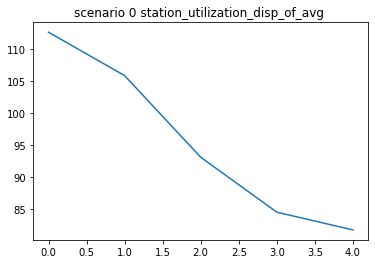

In [261]:
indices = {"min": 0, "med": 1, "max": 2, "mean": 3, "std":4}

def plot_scenario_metric(scenarios_df, scenario_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["scenario_number"]==scenario_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.plot(list(range(len(data))), data)
    measurement_str = measurement if measurement != None else ""
    plt.title("scenario " + str(scenario_index) + " " + metric + " " + measurement_str)
    
def plot_algorithm_iteration_metric(scenarios_df, alg_index, metric="station_utilization_disp_of_avg", measurement = None):
    df_slice = scenarios_df[scenarios_df["iteration"]==alg_index]
    if measurement == None:
        data = df_slice[metric]
    else:
        data = [literal_eval(x)[indices[measurement]] for x in df_slice[metric]]
    plt.xticks(rotation=90)
    plt.bar(list(range(len(df_slice))), data, tick_label = ["baseline"])
    measurement_str = measurement if measurement != None else ""
    plt.title("iteration " + str(alg_index) + " " + metric + " " + measurement_str)

plot_scenario_metric(scenarios_df, 0, "station_utilization_disp_of_avg")
# plot_scenario_metric(scenarios_df, 0, "hours_spent_in_queues", "mean")
# plot_algorithm_iteration_metric(scenarios_df, 0, "percent_delay", "med")
# plot_algorithm_iteration_metric(scenarios_df, 0, "station_utilization_disp_of_avg")

In [166]:
literal_eval(scenarios_df.iloc[0]["percent_delay"])

(1.0, 1.0, 2.6847547623266417, 1.0520741823128044, 0.200978947575907)

# Metric Validation

In [14]:
# Load data 
file_path = "trials/wednesday_debug_2/"
pkls = os.listdir(file_path)
for pkl in pkls:
    with open(file_path + pkl, 'rb') as inp:
        res = pickle.load(inp)
    break

## Percent Delay

### Validate hours spent in queues and hours spent charging

In simulation

In [15]:
print("Hours spent in queues:", res.get_hours_spent_in_queues())
print("Hours spent charging:", res.get_hours_spent_charging())

Hours spent in queues: (0.0, 0.0, 6.2, 0.3182389937106918, 1.1952134803610286)
Hours spent charging: (0, 0.0, 11, 0.8553459119496856, 2.760540640666715)


In [16]:
res.vehicle_list[0].locations
# res.vehicle_list[0].location_types

[('Long Beach_src', '9_100_out'),
 ('Long Beach_src', '9_100_out'),
 ('Long Beach_src', '9_100_out'),
 ('9_100_out', '27_20_in'),
 ('9_100_out', '27_20_in'),
 ('9_100_out', '27_20_in'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_20_in', '27_60_out'),
 ('27_60_out', '22_0_in'),
 ('27_60_out', '22_0_in'),
 ('27_60_out', '22_0_in'),
 ('27_60_out', '22_0_in'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_0_in', '22_100_out'),
 ('22_

In [17]:
queue_lengths = vehicle_list_data.get_node_queue_lengths(res)
vehicles_in_queues = {}
for sim_index in queue_lengths:
    vehicles_in_queues[sim_index] = sum(queue_lengths[sim_index].values())

In [22]:
get_edge_type_frequencies(res.vehicle_list[7000])

{'queue': 0, 'charging': 13, 'road': 4, 'src': 3, 'dst': 0}

### Delay metric

In simulation

In [8]:
print("Percent delay:", res.get_percent_delay())

Percent delay: (1.0, 1.3259882524244162, 8.837217478667803, 2.6497391091341984, 2.1767564664604575)


## Utilization

In simulation

In [9]:
print("Avg of station utilization dispersion:", res.get_station_utilization_avg_of_disp())


Avg of station utilization dispersion: 85.22200520833333


## Peak Demand Exceedance

In simulation

In [10]:
print("Electricity peak excceedance:", res.get_electricity_metric())

Electricity peak excceedance: 0
